In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #seabornない人はpip installしてね
import os
from datetime import datetime

# カレントディレクトリを.pyと合わせるために以下を実行
from pathlib import Path
if Path.cwd().name == "notebook":
    os.chdir("..")


# 設定
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_columns', 500)
# 浮動小数点数を小数点以下3桁で表示するように設定
pd.set_option('display.float_format', '{:.3f}'.format)


In [2]:
# Mac Matplotlibのデフォルトフォントをヒラギノ角ゴシックに設定
plt.rcParams['font.family'] = 'Hiragino Sans'

In [3]:
# Windows MatplotlibのデフォルトフォントをMeiryoに設定
plt.rcParams['font.family'] = 'Meiryo'

In [5]:
# CSVファイルを読み込む
file_path = 'data/input/gacha_history.csv'  # ファイルパスを適切に設定してください
df = pd.read_csv(file_path)

In [6]:
df.describe()

,id,user_uid,mission_type_id,add_ticket
count,1846907.000,1846907.000,1846907.000,1846907.000
mean,923455.459,54507.219,1.111,0.067
std,533157.869,35221.334,1.796,2.750
min,1.000,1.000,0.000,-300.000
25%,461727.500,16238.000,0.000,-1.000
50%,923454.000,60264.000,1.000,1.000
75%,1385182.500,88784.000,1.000,1.000
max,1846993.000,105518.000,14.000,300.000


In [7]:
df.columns

Index(['id', 'user_uid', 'mission_type_id', 'add_ticket',
       'mission_achievement_date', 'get_ticket_date', 'updated_at'],
      dtype='object')

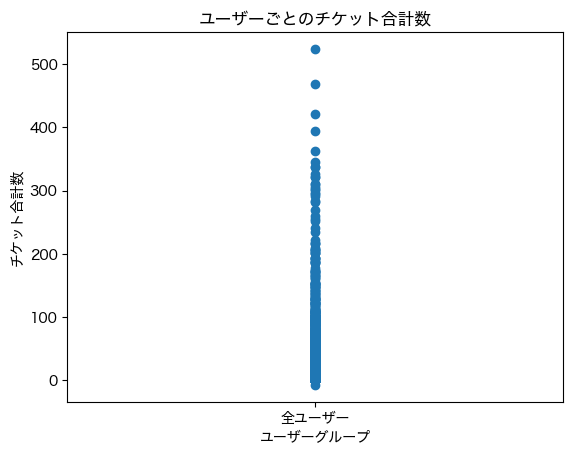

In [42]:
total_tickets_per_user = df.groupby(['user_uid'], observed=True)[
    'add_ticket'].sum()

# 散布図を描画するためのy座標のみを準備（x座標は必要ない）
y = total_tickets_per_user.values

# 散布図を描画（x座標は全て1として固定）
fig, ax = plt.subplots()
ax.scatter([1] * len(y), y)

ax.set_title('ユーザーごとのチケット合計数')
ax.set_xlabel('ユーザーグループ')
ax.set_ylabel('チケット合計数')

# x軸の目盛りを調整
ax.set_xticks([1])
ax.set_xticklabels(['全ユーザー'])

plt.show()


0 5


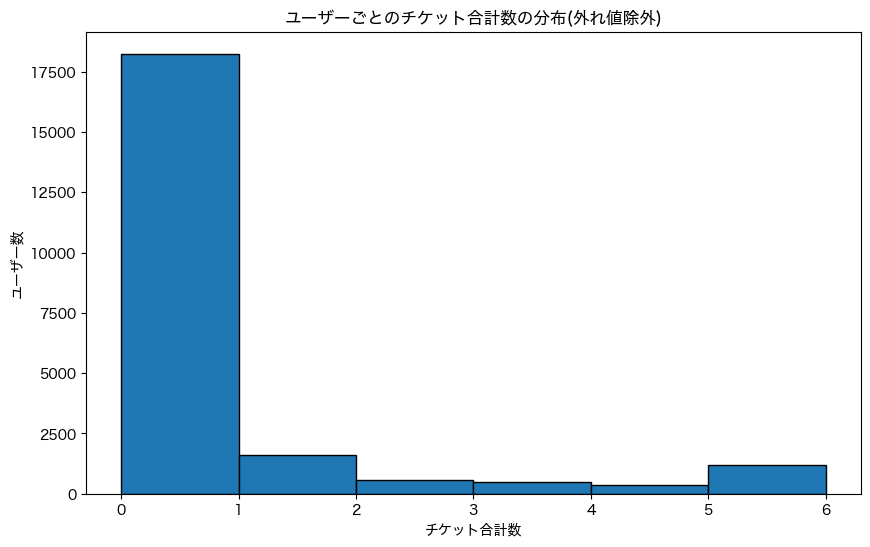

In [33]:
# 第一四分位数（Q1）と第三四分位数（Q3）を計算
Q1 = total_tickets_per_user.quantile(0.25)
Q3 = total_tickets_per_user.quantile(0.75)

# 四分位範囲（IQR）を計算
IQR = Q3 - Q1

# 外れ値の範囲を定義
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を除外
filtered_data = total_tickets_per_user[(total_tickets_per_user >= lower_bound) & (total_tickets_per_user <= upper_bound)]

# ヒストグラムのビンの数を10分割に設定
bin_count = 6

# チケットの最小値と最大値を取得
min_tickets = min(filtered_data)
max_tickets = max(filtered_data)
print(min_tickets,max_tickets)

# ビンの幅を計算
# bin_width = (max_tickets - min_tickets) / bin_count
bin_width = 1

# ビンの範囲を設定
bins = [min_tickets + i * bin_width for i in range(bin_count + 1)]

# ヒストグラムを描画
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=bins, edgecolor='black')
plt.title('ユーザーごとのチケット合計数の分布(外れ値除外)')
plt.xlabel('チケット合計数')
plt.ylabel('ユーザー数')
# plt.xticks(range(min(total_tickets_per_user), max(total_tickets_per_user) + 1))
plt.show()

In [ ]:
# ミッション達成日時ごとの一人当たりの獲得チケット量
average_ticket_by_decade = data.groupby('mission_achievement_date', observed=True)['add_ticket'].mean()
print(average_ticket_by_decade)

# 棒グラフで表示
plt.bar(average_ticket_by_decade.index, average_ticket_by_decade)

mission_achievement_date
2023-03-23    1.000
2023-03-24    1.000
2023-03-25    1.000
2023-03-26    1.000
2023-03-27    1.000
2023-03-28    1.000
2023-03-29    1.000
2023-03-30    1.000
2023-03-31    0.815
2023-04-01    0.358
2023-04-02    0.300
2023-04-03    0.212
2023-04-04    0.133
2023-04-05    0.269
2023-04-06    0.179
2023-04-07    0.205
2023-04-08    0.321
2023-04-09    0.117
2023-04-10    0.094
2023-04-11    0.117
2023-04-12    0.075
2023-04-13    0.059
2023-04-14    0.076
2023-04-15   -0.027
2023-04-16    0.079
2023-04-17    0.071
2023-04-18    0.088
2023-04-19    0.028
2023-04-20    0.070
2023-04-21    0.026
2023-04-22    0.067
2023-04-23    0.057
2023-04-24    0.114
2023-04-25    0.057
2023-04-26   -0.044
2023-04-27    0.020
2023-04-28    0.070
2023-04-29    0.014
2023-04-30    0.042
2023-05-01    0.049
2023-05-02    0.030
2023-05-03    0.047
2023-05-04    0.029
2023-05-05    0.233
2023-05-06   -0.010
2023-05-07    0.029
2023-05-08    0.070
2023-05-09    0.046
2023-05-10    0

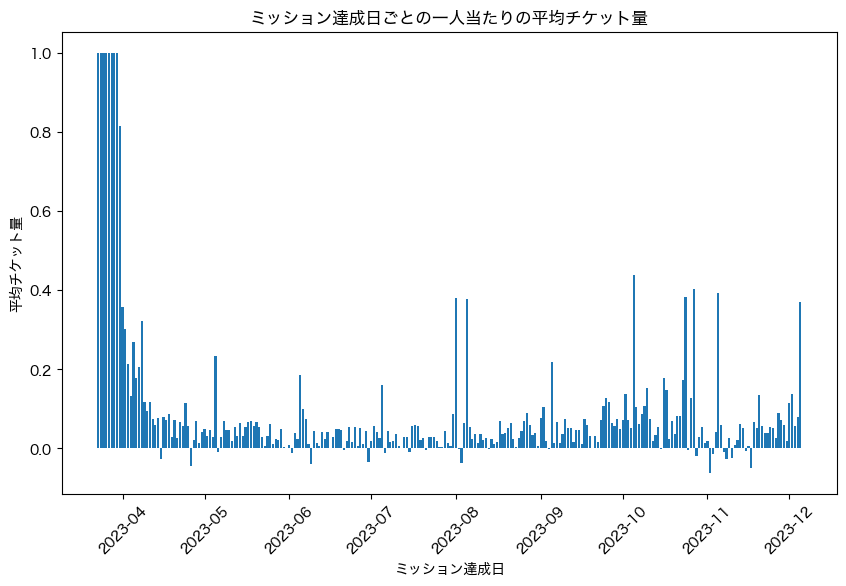

In [58]:
# ミッション達成日時のデータ型を確認し、日付型に変換
df['mission_achievement_date'] = pd.to_datetime(df['mission_achievement_date'])

# ミッション達成日ごとにグループ化して一人当たりの平均チケット量を計算
# 日時データから日付のみを抽出
df['mission_achievement_date'] = df['mission_achievement_date'].dt.date
# TODO: 2023/3/22のデータはそこまで多くなかったので、バグってます。修正してください。
df = df[df['mission_achievement_date'] != datetime(2023, 3, 22)] # この日がなぜか爆発的に多いため除外
average_ticket_by_date = df.groupby('mission_achievement_date')['add_ticket'].mean()
print(average_ticket_by_date)

# 棒グラフで表示
plt.figure(figsize=(10, 6))
plt.bar(average_ticket_by_date.index, average_ticket_by_date)
plt.title('ミッション達成日ごとの一人当たりの平均チケット量')
plt.xlabel('ミッション達成日')
plt.ylabel('平均チケット量')
plt.xticks(rotation=45)
plt.show()

In [9]:
# mission_type_id 毎の数を算出
# 棒グラフにプロット

n_mission_type_id = df["mission_type_id"].value_counts().sort_index()
print(n_mission_type_id)

mission_type_id
0     772243
1     757386
2      86448
3      79037
4      50863
5      76889
8          9
9          8
11      2931
12     15494
14      5599
Name: count, dtype: int64


・mission_type_idの6（古紙の持込重量ミッション(来月)）,10（チケット条件一致付与(メール)）がない  
・7と13はそもそも存在しない  

In [14]:
df_admin = df[(df["mission_type_id"]==8) | (df["mission_type_id"]==9)]
#print(df_admin)
df_admin

,id,user_uid,mission_type_id,add_ticket,mission_achievement_date,get_ticket_date,updated_at
555156,555157,38423,8,1,2023-07-31 22:38:10,2023-07-31 22:38:10,2023-07-31 22:38:10
555167,555168,38423,9,1,2023-07-31 22:38:34,2023-07-31 22:38:34,2023-07-31 22:38:34
607088,607089,14129,8,100,2023-08-05 11:55:41,2023-08-05 11:55:41,2023-08-05 11:55:41
672801,672802,41823,8,10,2023-08-11 18:46:20,2023-08-11 18:46:20,2023-08-11 18:46:20
724675,724676,448,8,100,2023-08-17 17:49:41,2023-08-17 17:49:41,2023-08-17 17:49:41
860385,860386,2808,8,300,2023-09-02 12:05:56,2023-09-02 12:05:56,2023-09-02 12:05:56
862674,862675,77745,8,2,2023-09-02 17:13:59,2023-09-02 17:13:59,2023-09-02 17:13:59
868205,868206,2808,8,-300,2023-09-03 08:49:41,2023-09-03 08:49:41,2023-09-03 08:49:41
934497,934498,88467,9,5,2023-09-09 19:57:56,2023-09-09 19:57:56,2023-09-09 19:57:56
977531,977534,5993,8,5,2023-09-14 14:05:13,2023-09-14 14:05:13,2023-09-14 14:05:13


・このあたりのデータは削除でよいのではないか

ガチャの効果を測定する  
・ガチャとリサイクル量の相関  
・ログインとリサイクル量の相関

# 以降、結合を試しています
# ※point_historyのデータも含む

In [34]:
# user_info とidを紐づけ（試し）
file_path_user_info = 'data/input/user_info_cleansing.csv'  # ファイルパスを適切に設定してください
df_user_info = pd.read_csv(file_path_user_info)
#df_user_info.head()

In [48]:
# merge (左内部結合)
df_merge = pd.merge(df, df_user_info, left_on='user_uid', right_on='id', how='left')

In [50]:
display(df_merge.head(100))
display(df_merge.describe())
#print(len(df_merge["user_uid"].unique()))
#print(df_merge.info(verbose=True, show_counts=True))
print(df_merge['nickname'].isna().sum())

,id_x,user_uid,mission_type_id,add_ticket,mission_achievement_date,get_ticket_date,updated_at,Unnamed: 0,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode
0,1,38423,1,100,2023-03-22 22:59:06,2023-03-22 22:59:06,2023-03-22 22:59:06,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,1994-01-01,9800811.000
1,2,72,5,1,2023-03-23 09:20:21,2023-03-23 09:20:21,2023-03-23 09:20:21,70019.000,72.000,テスト,2786.000,1.000,1314.000,350.200,0.000,0.000,男,2020-03-15 00:00:00,9830034.000
2,3,72,5,1,2023-03-23 09:20:50,2023-03-23 09:20:50,2023-03-23 09:20:50,70019.000,72.000,テスト,2786.000,1.000,1314.000,350.200,0.000,0.000,男,2020-03-15 00:00:00,9830034.000
3,4,38423,2,1,2023-03-24 12:00:00,2023-03-31 22:22:06,2023-03-31 22:22:06,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,1994-01-01,9800811.000
4,5,38423,1,1,2023-03-31 22:22:26,2023-03-31 22:22:26,2023-03-31 22:22:26,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,1994-01-01,9800811.000
5,6,38423,0,-1,2023-03-31 22:22:33,2023-03-31 22:22:33,2023-03-31 22:22:33,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,1994-01-01,9800811.000
6,7,38423,0,-2,2023-03-31 22:22:52,2023-03-31 22:22:52,2023-03-31 22:22:52,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,1994-01-01,9800811.000
7,8,74606,1,1,2023-03-31 22:28:27,2023-03-31 22:28:27,2023-03-31 22:28:27,72725.000,74606.000,だだだ,262.000,0.000,131.000,131.000,0.000,0.000,男,1989-09-14 00:00:00,9790147.000
8,9,74606,4,5,2023-03-31 22:28:30,2023-03-31 22:28:30,2023-03-31 22:28:30,72725.000,74606.000,だだだ,262.000,0.000,131.000,131.000,0.000,0.000,男,1989-09-14 00:00:00,9790147.000
9,10,74606,0,-6,2023-03-31 22:28:38,2023-03-31 22:28:38,2023-03-31 22:28:38,72725.000,74606.000,だだだ,262.000,0.000,131.000,131.000,0.000,0.000,男,1989-09-14 00:00:00,9790147.000


,id_x,user_uid,mission_type_id,add_ticket,Unnamed: 0,id_y,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,zipcode
count,1846907.000,1846907.000,1846907.000,1846907.000,1805199.000,1805199.000,1805199.000,1805199.000,1805199.000,1805199.000,1805199.000,1805199.000,1741660.000
mean,923455.459,54507.219,1.111,0.067,58499.850,53859.749,1548.089,13.286,320.906,206.490,7.166,0.610,6465265.578
std,533157.869,35221.334,1.796,2.750,30888.243,35127.405,2272.527,58.566,669.054,453.244,22.594,1.064,3312734.899
min,1.000,1.000,0.000,-300.000,3.000,72.000,0.000,0.000,0.000,0.000,0.000,0.000,1167189.000
25%,461727.500,16238.000,0.000,-1.000,31220.000,15512.000,271.000,0.000,74.000,65.000,0.000,0.000,3150001.000
50%,923454.000,60264.000,1.000,1.000,64263.000,59574.000,614.000,0.000,181.000,136.000,0.000,0.000,9600101.000
75%,1385182.500,88784.000,1.000,1.000,86781.000,88351.000,2142.000,0.000,370.000,218.000,0.000,1.000,9810952.000
max,1846993.000,105518.000,14.000,300.000,99818.000,105512.000,51900.000,3614.000,16880.000,12640.000,149.700,5.000,9996401.000


42225


・user_info は最近やってなかったユーザーを消しているのか？  
・user_info は宮城県で絞ってないか？  
-> user_infoをどのように抽出したかの詳細を聞く必要がある

In [52]:
# point_history と user_info の紐づけ
file_path_point_history = 'data/input/point_history_cleansing.csv'  # ファイルパスを適切に設定してください
df_point_history = pd.read_csv(file_path_point_history)

C:\Users\noros\AppData\Local\Temp\ipykernel_21924\1897340225.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_point_history = pd.read_csv(file_path_point_history)


In [53]:
df_point_history.head()

,Unnamed: 0,id,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,total_amount,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude
0,0,22,2023,1.000,52.000,サン・マルシェ東中田店,superbig047780,1.000,2.000,2.000,2.000,98.000,1,NaN,0.000,0.000,2020-12-17 18:01:24,2020-12-17 18:01:24,2021-04-14 17:57:46,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901
1,1,27,90,1.000,52.000,サン・マルシェ東中田店,superbig011187,1.000,7.000,7.000,7.000,143.000,1,NaN,21.000,2.000,2020-12-18 10:59:56,2020-12-18 10:59:56,2020-12-31 13:57:54,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901
2,2,34,670,1.000,52.000,サン・マルシェ東中田店,superbig035909,1.000,5.000,5.000,5.000,7.000,1,NaN,5.000,0.000,2020-12-18 14:30:36,2020-12-18 14:30:36,2020-12-31 13:58:58,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901
3,3,38,725,1.000,52.000,サン・マルシェ東中田店,superbig016946,1.000,2.000,2.000,2.000,102.000,1,NaN,2.000,0.000,2020-12-18 18:31:55,2020-12-18 18:31:55,2020-12-31 13:59:25,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901
4,4,39,205,1.000,52.000,サン・マルシェ東中田店,superbig000727,1.000,9.000,9.000,19.000,1567.000,1,NaN,9.000,0.000,2020-12-18 18:44:35,2020-12-18 18:44:35,2020-12-31 13:56:51,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901


In [54]:
# merge (左内部結合)
df_merge_point = pd.merge(df_point_history, df_user_info, left_on='user_id', right_on='id', how='left')

In [57]:
display(df_merge_point.head(100))
display(df_merge_point.describe())
#print(len(df_merge["user_uid"].unique()))
#print(df_merge.info(verbose=True, show_counts=True))
print(df_merge_point['nickname'].isna().sum())

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,total_amount,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode
0,0,22,2023,1.000,52.000,サン・マルシェ東中田店,superbig047780,1.000,2.000,2.000,2.000,98.000,1,NaN,0.000,0.000,2020-12-17 18:01:24,2020-12-17 18:01:24,2021-04-14 17:57:46,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,16307.000,2023.000,みみ,100.000,57.000,110.200,34.160,0.000,0.000,男,1978-09-29 00:00:00,9811107.000
1,1,27,90,1.000,52.000,サン・マルシェ東中田店,superbig011187,1.000,7.000,7.000,7.000,143.000,1,NaN,21.000,2.000,2020-12-18 10:59:56,2020-12-18 10:59:56,2020-12-31 13:57:54,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,88794.000,90.000,なおちんママ,2088.000,72.000,771.000,123.100,0.000,0.000,女,1967-08-30 00:00:00,9811107.000
2,2,34,670,1.000,52.000,サン・マルシェ東中田店,superbig035909,1.000,5.000,5.000,5.000,7.000,1,NaN,5.000,0.000,2020-12-18 14:30:36,2020-12-18 14:30:36,2020-12-31 13:58:58,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,64855.000,670.000,ゆみ,146.000,135.000,140.800,0.000,0.000,0.000,女,1968-02-12 00:00:00,9811103.000
3,3,38,725,1.000,52.000,サン・マルシェ東中田店,superbig016946,1.000,2.000,2.000,2.000,102.000,1,NaN,2.000,0.000,2020-12-18 18:31:55,2020-12-18 18:31:55,2020-12-31 13:59:25,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,70536.000,725.000,みい,1595.000,146.000,192.200,0.000,0.000,0.000,女,1988-06-28 00:00:00,9811103.000
4,4,39,205,1.000,52.000,サン・マルシェ東中田店,superbig000727,1.000,9.000,9.000,19.000,1567.000,1,NaN,9.000,0.000,2020-12-18 18:44:35,2020-12-18 18:44:35,2020-12-31 13:56:51,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,16580.000,205.000,Tomoo,831.000,139.000,553.500,111.100,0.000,0.000,女,1970-05-10 00:00:00,9811102.000
5,5,43,205,1.000,52.000,サン・マルシェ東中田店,superbig000727,1.000,7.000,7.000,7.000,1574.000,1,NaN,7.000,0.000,2020-12-19 11:20:13,2020-12-19 11:20:13,2020-12-31 13:56:43,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,16580.000,205.000,Tomoo,831.000,139.000,553.500,111.100,0.000,0.000,女,1970-05-10 00:00:00,9811102.000
6,6,60,539,1.000,52.000,サン・マルシェ東中田店,superbig053591,1.000,25.000,25.000,25.000,98.000,1,NaN,25.000,0.000,2020-12-19 16:49:40,2020-12-19 16:49:40,2020-12-31 14:01:51,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,51271.000,539.000,櫻井智子,2088.000,243.000,620.500,143.000,0.000,0.000,女,1970-11-04 00:00:00,9820003.000
7,7,61,162,1.000,52.000,サン・マルシェ東中田店,superbig013909,1.000,8.000,8.000,8.000,166.000,1,NaN,8.000,0.000,2020-12-19 16:53:02,2020-12-19 16:53:02,2020-12-31 14:01:29,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,12110.000,162.000,otchi1,36.000,122.000,594.500,210.200,71.000,3.000,女,1966-08-13 00:00:00,9811102.000
8,8,82,158,1.000,52.000,サン・マルシェ東中田店,superbig034486,1.000,14.000,14.000,14.000,150.000,1,NaN,42.000,2.000,2020-12-28 10:46:27,2020-12-28 10:46:27,2020-12-31 14:02:44,19.000,サン・マルシェ,東中田店,52.000,2021-09-21 04:25:00,2023-09-20 15:59:08,09:00:00,21:00:00,09:00:00,21:00:00,38.203,140.901,11693.000,158.000,ゆかりん,1035.000,184.000,1167.000,327.000,0.000,0.000,女,1974-01-17 00:00:00,9811101.000
9,9,94,230,1.000,52.000,サン・マルシェ東中田店,superbig036861,1.000,10.00

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,total_amount,coin,rank_id,支店ID,store_latitude,store_longitude,Unnamed: 0_y,id_y,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,zipcode
count,2149728.000,2149728.000,2149728.000,1295685.000,1253882.000,1253884.000,1253888.000,1253884.000,2105409.000,1253883.000,2149728.000,0.000,2149724.000,2147086.000,1248489.000,1243893.000,1243893.000,2124940.000,2124940.000,2124940.000,2124940.000,2124940.000,2124940.000,2124940.000,2124940.000,1983956.000
mean,1085361.322,11863325.458,42111.151,8.435,669.300,1.003,9.121,9.101,1.661,26.813,3.259,NaN,34.433,0.755,166.241,37.695,140.475,49514.926,41793.931,1647.827,21.219,406.783,239.305,6.096,0.532,7382044.960
std,623743.634,3891833.683,32727.141,2.022,1612.244,0.102,9.678,9.654,12.884,91.546,2.810,NaN,322.394,1.101,116.977,0.931,0.418,29697.271,32557.613,2798.503,75.968,888.390,617.446,21.723,0.982,3180866.085
min,0.000,22.000,1.000,1.000,9.000,1.000,0.000,0.000,0.000,0.000,1.000,NaN,-20000.000,0.000,3.000,35.853,139.081,3.000,62.000,0.000,0.000,0.000,0.000,0.000,0.000,1000006.000
25%,546351.750,9691203.500,11074.000,9.000,305.000,1.000,4.000,4.000,0.000,0.000,1.000,NaN,1.000,0.000,73.000,36.918,140.142,22454.000,11011.000,278.000,0.000,101.000,72.000,0.000,0.000,3210932.000
50%,1086521.500,12993836.500,35809.000,9.000,772.000,1.000,7.000,7.000,0.000,0.000,1.000,NaN,6.000,0.000,151.000,37.803,140.448,48328.000,35319.000,852.000,0.000,215.000,139.000,0.000,0.000,9638041.000
75%,1625353.250,14890424.250,72672.000,9.000,986.000,1.000,11.000,11.000,0.000,0.000,7.000,NaN,16.000,1.000,232.000,38.294,140.872,77187.000,72006.000,2056.000,0.000,415.000,224.000,0.000,1.000,9820026.000
max,2164431.000,16576491.000,105518.000,20.000,1239999.000,4.000,503.000,503.000,2200.000,4216.000,7.000,NaN,15000.000,3.000,530.000,39.712,141.367,99819.000,105512.000,59900.000,3614.000,16880.000,15460.000,149.700,5.000,9999999.000


25190


In [46]:
df_user_info.columns

Index(['Unnamed: 0', 'id', 'nickname', 'club_coin', 'recycle_point',
       'total_recycle_amount', 'recycle_amount_per_year',
       'recycle_amount_after_gold_member', 'rank_continuation_class', 'gender',
       'birth_day', 'zipcode'],
      dtype='object')